# Congestion control algorithm

## Run experiments

In [1]:
import sem
import numpy as np
import pandas as pd
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# Create our SEM campaign
ns_3_dir = '../../../../'
script = 'congestion-example'
results_dir = 'results'
campaign = sem.CampaignManager.new(ns_3_dir, script, results_dir,
                                   check_repo=False, overwrite=True,
                                   optimized=False, skip_configuration=True)


In [2]:
def compute_area(rings, range=2426.85):
    disc = (range / 1000)**2 * np.pi

    if (rings == 1):
        return disc

    radius = range * np.cos(np.pi / 6)
    ngateways = 3 * rings * rings - 3 * rings + 1

    hexag = range / 1000 * radius / 1000 * 3
    # internal hexagons area + vertices area + sides area
    return (ngateways - 6 * (rings - 1)) * hexag + 3 * (hexag + disc) + 2 * (rings - 2) * (2 * hexag + disc)


In [16]:
# density for device position
int(np.rint(10 * compute_area(2))) / compute_area(1)


1.618033988749895

In [3]:
# Define the parameter space we are interested in exploring
rings = 2
params = {
    "devices": int(np.rint(200 * compute_area(rings))),
    "periods": 0.1,
    "file": True,
    "sir": "CROCE",
    "rings": rings
}
runs = 30

# Run simulations with the above parameter space
campaign.run_missing_simulations(params, runs)


Running simulations: 100%|██████████| 30/30 [04:00<00:00,  8.02s/simulation]


## Device positions, per SF

In [9]:
@sem.utils.yields_multiple_results
@sem.utils.output_labels(['X Position [m]', 'Y Position [m]', 'SF'])
def get_device_position_sf (result):
    """
    Extract the position and SF of each device from deviceStatus.txt
    """
    df = pd.read_csv(StringIO(result['output']['deviceStatus.txt']), sep=" ", header=None)
    df.columns = ['time','id','xpos','ypos','zpos','gwdist','dr','txpow','sent','received','devOT','aggDC','cluster']
    df['sf'] = 12 - df['dr'].to_numpy()
    return df[['xpos','ypos','sf']].to_numpy().tolist()

In [10]:
results = campaign.get_results_as_dataframe(get_device_position_sf,
                                            params=params,
                                            parallel_parsing=True)
results['SF'] = results['SF'].astype(int)
results

,devices,periods,file,sir,rings,change,initSF,clusters,sampling,variance,...,load,range,add,save,warmup,remove,RngRun,X Position [m],Y Position [m],SF
0,7361,0.1,True,CROCE,2,0.0,True,None,2.0,0.01,...,None,2426.85,0.0,None,0.0,0.0,0,-491.526,2389.400,10
1,7361,0.1,True,CROCE,2,0.0,True,None,2.0,0.01,...,None,2426.85,0.0,None,0.0,0.0,0,1562.040,3586.500,10
2,7361,0.1,True,CROCE,2,0.0,True,None,2.0,0.01,...,None,2426.85,0.0,None,0.0,0.0,0,374.152,-1217.250,9
3,7361,0.1,True,CROCE,2,0.0,True,None,2.0,0.01,...,None,2426.85,0.0,None,0.0,0.0,0,-3216.750,-912.980,8
4,7361,0.1,True,CROCE,2,0.0,True,None,2.0,0.01,...,None,2426.85,0.0,None,0.0,0.0,0,2277.620,-4513.920,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7356,7361,0.1,True,CROCE,2,0.0,True,None,2.0,0.01,...,None,2426.85,0.0,None,0.0,0.0,0,-582.156,884.981,7
7357,7361,0.1,True,CROCE,2,0.0,True,None,2.0,0.01,...,None,2426.85,0.0,None,0.0,0.0,0,-1170.960,4733.580,11
7358,7361,0.1,True,CROCE,2,0.0,True,None,2.0,0.01,...,None,2426.85,0.0,None,0.0,0.0,0,-112.701,-5587.850,9
7359,7361,0.1,True,CROCE,2,0.0,True,None,2.0,0.01,...,None,2426.85,0.0,None,0.0,0.0,0,-4516.280,532.308,10


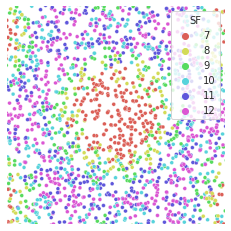

In [22]:
fileformat = 'pdf'
plots_dir = 'plots'
filename = 'SFposition'

lim = 2700
g = sns.scatterplot(data=results, x='X Position [m]', y='Y Position [m]', hue="SF", palette=sns.color_palette("hls", 6), s=15)
g.set (xlim=(-lim,lim), ylim=(-lim,lim))
g.axes.set_box_aspect(1)
g.axis('off')
sns.move_legend(g, "upper right")
plt.savefig('{0}/{1}.{2}'.format(plots_dir,filename,fileformat), bbox_inches='tight')
plt.show()

## SF distribution

In [4]:
@sem.utils.yields_multiple_results
@sem.utils.output_labels(['Distance [m]', 'SF'])
def get_device_distance_sf(result):
    """
    Extract the position and SF of each device from deviceStatus.txt
    """
    df = pd.read_csv(
        StringIO(result['output']['deviceStatus.txt']), sep=" ", header=None)
    df.columns = ['time', 'id', 'xpos', 'ypos', 'zpos', 'gwdist',
                  'dr', 'txpow', 'sent', 'received', 'devOT', 'aggDC', 'cluster']
    df['sf'] = 12 - df['dr'].to_numpy()
    return df[['gwdist', 'sf']].to_numpy().tolist()


In [6]:
results = campaign.get_results_as_dataframe(get_device_distance_sf,
                                            params=params,
                                            parallel_parsing=True)
results['SF'] = results['SF'].astype(int)
results


,devices,periods,file,sir,rings,add,target,load,adr,save,...,remove,beta,clusters,range,tolerance,warmup,congest,RngRun,Distance [m],SF
0,23343,0.1,True,CROCE,2,0.0,0.95,None,False,None,...,0.0,1.0,None,2426.85,0.001,0.0,False,8,1845.06,12
1,23343,0.1,True,CROCE,2,0.0,0.95,None,False,None,...,0.0,1.0,None,2426.85,0.001,0.0,False,8,2045.68,11
2,23343,0.1,True,CROCE,2,0.0,0.95,None,False,None,...,0.0,1.0,None,2426.85,0.001,0.0,False,8,1536.19,9
3,23343,0.1,True,CROCE,2,0.0,0.95,None,False,None,...,0.0,1.0,None,2426.85,0.001,0.0,False,8,2012.13,10
4,23343,0.1,True,CROCE,2,0.0,0.95,None,False,None,...,0.0,1.0,None,2426.85,0.001,0.0,False,8,1210.04,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700285,23343,0.1,True,CROCE,2,0.0,0.95,None,False,None,...,0.0,1.0,None,2426.85,0.001,0.0,False,21,2069.36,11
700286,23343,0.1,True,CROCE,2,0.0,0.95,None,False,None,...,0.0,1.0,None,2426.85,0.001,0.0,False,21,1732.10,10
700287,23343,0.1,True,CROCE,2,0.0,0.95,None,False,None,...,0.0,1.0,None,2426.85,0.001,0.0,False,21,1354.77,10
700288,23343,0.1,True,CROCE,2,0.0,0.95,None,False,None,...,0.0,1.0,None,2426.85,0.001,0.0,False,21,2248.51,11


In [8]:
df = results.groupby('SF')['devices'].count().reset_index()
df['Percentage (%)'] = 100 * df['devices'] / df['devices'].sum()
df


,SF,devices,Percentage (%)
0,7,150892,21.547073
1,8,58233,8.315555
2,9,80970,11.562353
3,10,112187,16.020077
4,11,128648,18.370675
5,12,169360,24.184267


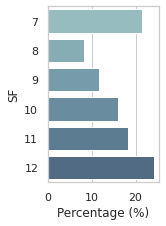

In [20]:
fileformat = 'pdf'
plots_dir = 'plots'
filename = 'SFpercentage'

gold = (1 + 5 ** 0.5) / 2
w = 2
sns.set(style='whitegrid', rc={'figure.figsize':(w,w*gold)})
sns.barplot(data=df, x='Percentage (%)', y='SF',
            palette=sns.cubehelix_palette(10, rot=-.25, light=.7), orient='h')
plt.savefig('{0}/{1}.{2}'.format(plots_dir, filename, fileformat), bbox_inches='tight')
plt.show()


/home/alle/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/alle/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/alle/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/alle/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


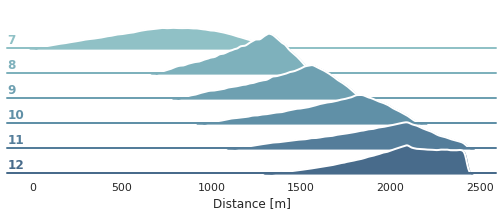

In [29]:
fileformat = 'pdf'
plots_dir = 'plots'
filename = 'SFdistance'

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(results, row="SF", hue="SF", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Distance [m]",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5, common_norm=True)
g.map(sns.kdeplot, "Distance [m]", clip_on=False, color="w", lw=2, bw_adjust=.5, common_norm=True)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Distance [m]")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.4)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.savefig('{0}/{1}.{2}'.format(plots_dir,filename,fileformat), bbox_inches='tight')

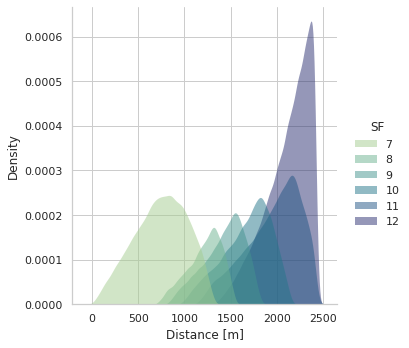

In [113]:
fileformat = 'pdf'
plots_dir = 'congestion-plots'
filename = 'SFdistance'

sns.set_style('whitegrid')

sns.displot(data=results, x="Distance [m]", hue="SF", kind="kde",fill=True, common_norm=True, palette="crest",
   alpha=.5, linewidth=0,)
plt.savefig('{0}/{1}.{2}'.format(plots_dir,filename,fileformat))
plt.show ()